# Programa Ejemplo para la sintonización de hiperparámetros en redes neuronales (Regularización).

En este ejemplo se estudia cómo usar la búsqueda de hiperparámetros para determinar, de forma adecuada, la regularización. En este ejemplo solo se usa el dropout; sin embargo, se puede extender a la regularización L1 y L2.

## Etapa 1: Carga de los datos.

Antes de comenzar a definir la red neuronal, cargamos la base de datos de interés. Para este ejemplo, usaremos la base de datos MNIST, la cual consiste en identificar dígitos escritos a mano alzada https://keras.io/api/datasets/mnist/. Esta base de datos configura un problema de 10 clases, una clase por cada dígito numérico (0-9).

Se cargan las librerías necesarias

In [12]:
!pip install keras-tuner --upgrade

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.utils import plot_model
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from keras_tuner import RandomSearch

Se carga la base de datos y se divide en los conjunto de entrenamiento y prueba. Hay 60000 imágenes para el entrenamiento y 10000 en el conjunto de prueba.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Se divide el train en validation

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

In [5]:

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(54000, 28, 28) (54000,) (6000, 28, 28) (6000,)


Las imágenes tienen tamaño 28x28. A continuación de muestran algunos ejemplos.


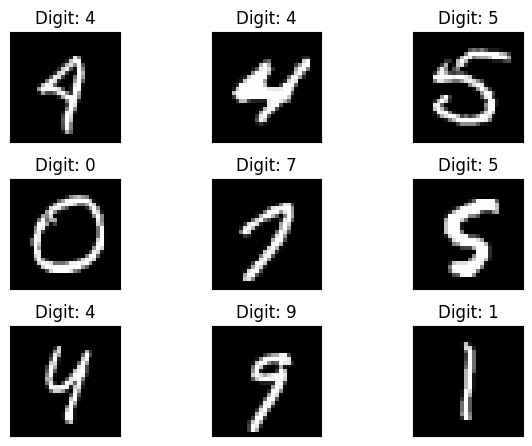

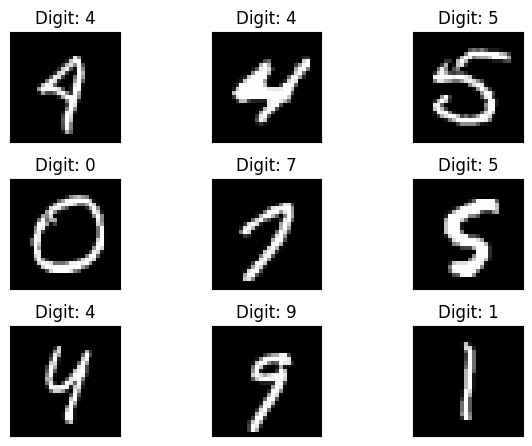

In [6]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
d1, d2, d3 = x_train.shape
x_train_flat = x_train.reshape((d1, d2*d3))/255
d1, d2, d3 = x_test.shape
x_test_flat = x_test.reshape((d1, d2*d3))/255
d1, d2, d3 = x_val.shape
x_val_flat = x_val.reshape((d1, d2 * d3)) / 255

print(x_train_flat.shape, x_test_flat.shape, x_val_flat.shape)

(54000, 784) (10000, 784) (6000, 784)



# Búsqueda de hiperparámetros a partir de la búsqueda aleatoria

Ejemplo avanzado donde el número de capas también se trata como un hiperparámetro

In [8]:
# Número de épocas para los experimentos
epochs = 5

In [9]:
def build_model_1(hp):
  model = Sequential()
  for i in range(hp.Int('num_layers', 1, 3, 1)): # range(2)
    model.add(Dense(units = hp.Choice('units'+str(i+1), [256, 512]), activation = hp.Choice('activation'+str(i+1), ['relu', 'sigmoid'])))
    if hp.Boolean("dropout"+str(i+1)):
        model.add(Dropout(rate=hp.Choice('DropRate'+str(i+1), [0.2, 0.4, 0.6]),))
  model.add(Dense(10, activation = 'softmax'))
  optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.01, 0.001]))
  model.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

In [10]:
tuner_1 = RandomSearch(build_model_1, objective = 'val_loss', max_trials = 10)
tuner_1.search(x_train_flat, y_train, epochs = epochs, validation_data = (x_val_flat, y_val), verbose=2)
best_model_1 = tuner_1.get_best_models()[0]

Trial 20 Complete [00h 00m 26s]
val_loss: 0.12886084616184235

Best val_loss So Far: 0.07712353765964508
Total elapsed time: 00h 08m 45s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
test_loss, test_acc = best_model_1.evaluate(x_test_flat, y_test)
print('test_acc:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0655 - accuracy: 0.9809
test_acc: 0.98089998960495


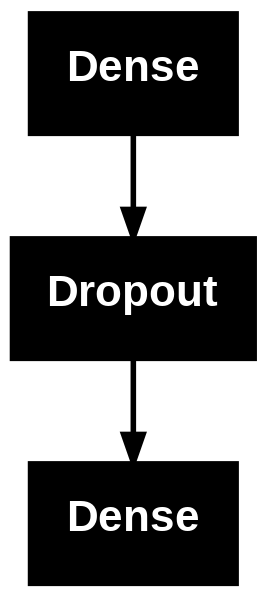

In [11]:
tf.keras.utils.plot_model(best_model_1)